# Quantum Programs Testing Tool

En este proyecto presentamos una herramienta que recibe un circuito cuántico, un valor inicial para los qubits de entrada (llamado input) y una distribución de resultados esperada (llamado oráculo). El programa procesa el input para crear un valor inicial para todos los qubits del programa cuántico, ejecuta dicho programa múltiples veces para obtener una distribución de resultados (llamada output), y finalmente comparar el output y el oráculo, con métodos estadísticos, para determinar si ambas distribuciones son equivalentes.

Para realizar dicho trabajo, primero importamos las librerías necesarias.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()

A continuación creamos funciones que nos devolverán los circuitos cuánticos (QC) que serán los programas cuánticos que vamos a testear.

In [2]:
def qc1():
    
    input_qubit = QuantumRegister(2, 'input_qubit')
    output_qubit = QuantumRegister(1, 'output_qubit')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(input_qubit, output_qubit, c)
    # Implementation statements
    qc.h(output_qubit)
    qc.cswap(output_qubit, input_qubit[0], input_qubit[1])
    qc.h(output_qubit)
    qc.x(output_qubit)
    qc.measure(output_qubit, c)
    
    return qc

In [3]:
def qc1_fail():
    
    input_qubit = QuantumRegister(2, 'input_qubit')
    output_qubit = QuantumRegister(1, 'output_qubit')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(input_qubit, output_qubit, c)
    # Implementation statements
    qc.h(output_qubit)
    qc.cswap(output_qubit, input_qubit[0], input_qubit[1])
    qc.x(output_qubit)
    qc.x(output_qubit)
    qc.measure(output_qubit, c)
    
    return qc

In [4]:
def qc2():
    
    input_qubit = QuantumRegister(2, 'input_qubit')
    output_qubit = QuantumRegister(1, 'output_qubit')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(input_qubit, output_qubit, c)
    # Implementation statements
    qc.ccx(input_qubit[0], input_qubit[1], output_qubit)
    qc.measure(output_qubit, c)
    
    return qc

La siguiente función genera automáticamente un array con los inputs a testear. Tiene dos modos:
- En el modo auto genera todos los posibles inputs del programa.
- En el modo custom genera sólo los imputs incluidos en la test_list.

In [5]:
#Función test_input_generator
#INPUTS: num_input_qubits: int, mode: string, test_list: array of ints
#OUTPUTS: input_array: array of arrays of ints
def test_input_generator(num_input_qubits=0, mode="auto", test_list=[]):

    input_array = []
    
    if mode == "auto":
        for i in range(2**num_input_qubits):
            bin_array = [int(x) for x in list('{0:{fill}{width}b}'.format(i, fill=0, width=num_input_qubits))]
            input_array.append(bin_array)
    elif mode == "custom":
        for i in test_list:
            bin_array = [int(x) for x in list('{0:{fill}{width}b}'.format(i, fill=0, width=num_input_qubits))]
            input_array.append(bin_array)
        
    return input_array

A continuación definimos dos funciones que generan el circuito necesario para generar la entrada selecionada:
- iqc_individual: genera el circuito que define un input poniendo los qubits necesarios a 1.
- iqc_superposition: genera el circuito que define la superposición de todos los posibles inputs.

In [6]:
#Función iqc_individual
#INPUTS: value: array of ints, num_total_qubits: int, num_cl_bits: int
#OUTPUTS: qc: QuantumCircuit
def iqc_individual(value=[], num_total_qubits=0, num_cl_bits=0):

    num_input_qubits = len(value)
    
    qr = QuantumRegister(num_total_qubits)
    cr = ClassicalRegister(num_cl_bits)
    
    qc = QuantumCircuit(qr, cr)
    
    index = 0
    
    for bit in value:
        if (bit == 1):
            qc.x(index)
        index += 1
    
    qc.barrier()
    return qc

In [7]:
#Función iqc_superposition
#INPUTS: num_inputs: int, num_total_qubits: int, num_cl_bits: int
#OUTPUTS: qc: QuantumCircuit
def iqc_superposition(num_inputs=0, num_total_qubits=0, num_cl_bits=0):
    
    qr = QuantumRegister(num_total_qubits)
    cr = ClassicalRegister(num_cl_bits)
    
    qc = QuantumCircuit(qr, cr)
    
    qc.barrier()
    
    index = 0
    #qc.x(index)
    #qc.x(index+1)
    
    for bit in range(num_inputs):
        qc.h(index)
        index += 1
    
    qc.barrier()
    return qc

La siguiente función testea el circuito. Para ello, primero compone el circuito de entrada con el circuito a testear, y a continuación ejecuta el circuito resultante *shots* veces. Finalmente, devuelve el histograma resultante.

In [8]:
#Función test_circuit
#INPUTS: iqc: QuantumCircuit, qc: QuantumCircuit, shots: int
#OUTPUTS: histogram: array of ints
def test_circuit(iqc, qc,  shots=1024):
    fqc = iqc.compose(qc)
    
    emulator = Aer.get_backend('qasm_simulator')
    job = execute(fqc, emulator, shots=shots) 

    # The result is a histogram in the form of a dictionary.
    histogram = job.result().get_counts()
    #print ('results: ', histogram)

    # plot histogram
    #legend = ['Execution results']
    #plot_histogram(histogram,legend=legend)
    
    return histogram

La siguente función genera un oráculo para la superposición de los inputs a partir de los oráculos individuales para los distintos inputs.

In [9]:
#Función oracle_union
#INPUTS: oracles: dict<string, dict<string, int>>
#OUTPUTS: oracle: dict<string, int>
def oracle_union(oracles):
    oracle = {}
    iters = 0
    for key, value in oracles.items():
        for k, v in value.items():
            if k in oracle:
                oracle[k] += v
            else:
                oracle[k] = v
        iters += 1
    for key, value in oracle.items():
        oracle[key] /= iters 
    return oracle

A continuación definimos la función que compara dos distribuciones de probabilidad a través de sus definiciones frequentistas. Para ello usa el estadístico Chi Cuadrado de Pearson.

In [10]:
#Función chi_square
#INPUTS: outputs: dict<string, int>, oracle: dict<string, int>
#OUTPUTS: boolean
def chi_square(outputs,oracle):
    if len(oracle) > 1 and len(outputs) > 1:
        alpha = 0.05
        outputs = [outputs[key] for key in sorted(outputs.keys())]
        oracle = [oracle[key] for key in sorted(oracle.keys())]
        oracle = np.multiply(oracle,np.sum(outputs)).astype(int)
        stat, pvalue = st.chisquare(outputs,oracle)
        #print("H-value: " + str(stat))
        #print("p-value: " + str(pvalue))
        #print()
        if pvalue > alpha:
            #print('Dependent (reject H0)')
            return True
        else:
            #print('Independent (fail to reject H0)')
            return False
    else:
        if oracle.keys() == outputs.keys():
            return True
        else:
            return False

Finalmente, definimos la función principal que combina todas las anteriores para ejecutar el testeo automático del programa cuántico que reciba. Para ello, tiene dos modos:
- Si se le pasa un conjunto de inputs a probar, testea el programa con esos inputs de forma secuencial, y compara los resultados obtenidos con sus respectivos oráculos.
- Si no se le pasa un conjunto de inputs, testea la superposición de todos los inputs con respecto a la unión de los oráculos.

In [11]:
#Función QPTT
#INPUTS: qc: QuantumCircuit, num_inputs: int, oracles: dict<string, dict<string, int>>, inputs_array: array of arrays of ints, shots: int
#OUTPUTS: void
def QPTT(qc, num_inputs, oracles, inputs_array=None, shots=1024):
    
    all_outputs=dict()
    oracles_superp=dict()
    
    if inputs_array != None:
        for inputs,oracle in zip(inputs_array,oracles.values()):
            # Get total number of qubits and classical bits
            num_total_qubits = qc.num_qubits
            num_cl_bits = qc.width() - num_total_qubits

            iqc = iqc_individual(value=inputs, num_total_qubits=num_total_qubits, num_cl_bits=num_cl_bits)
            outputs = test_circuit(iqc,qc,shots)
            input_str = [str(int) for int in inputs]
            all_outputs["".join(input_str)] = outputs
            result = chi_square(outputs, oracle)
            if result:
                print(f"Circuit passed evaluation for input {inputs}.")
            else:
                print(f"Circuit failed evaluation for input {inputs}! There is some error.")
                print(f"Circuit returned {outputs}")
    else:
        oracle = oracle_union(oracles)
        oracles_superp = oracle
        
        # Get total number of qubits and classical bits
        num_total_qubits = qc.num_qubits
        num_cl_bits = qc.width() - num_total_qubits

        iqc = iqc_superposition(num_inputs=num_inputs, num_total_qubits=num_total_qubits, num_cl_bits=num_cl_bits)
        outputs = test_circuit(iqc,qc,shots)
        all_outputs = outputs
        
        result = chi_square(outputs, oracle)
        if result:
            print(f"Circuit passed evaluation.")
        else:
            print(f"Circuit failed evaluation! There is some error.")
            print(f"Circuit returned {outputs}")
            
    return all_outputs, oracles_superp

Para comprobar la efectividad de nuestra herramienta, presentamos varios ejemplos de su uso.

El primer ejemplo es usando la herramienta para testear todos los posibles inputs del programa qc1:

In [12]:
input_array = test_input_generator(num_input_qubits=2, mode="auto", test_list=[1])
#print(input_array)

# Instantiate the quantum circuit under test
qc = qc1()

oracle = {'00':{'1':1},'01':{'0':0.5, '1':0.5},'10':{'0':0.5, '1':0.5},'11':{'1':1}}

outputs, oracle_superp = QPTT(qc, 2, oracle, inputs_array=input_array)

Circuit passed evaluation for input [0, 0].
Circuit passed evaluation for input [0, 1].
Circuit passed evaluation for input [1, 0].
Circuit passed evaluation for input [1, 1].


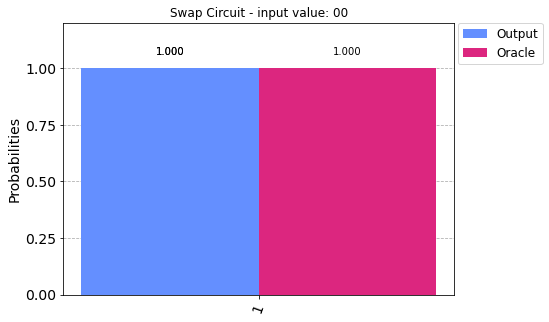

In [13]:
plot_histogram([outputs['00'], oracle['00']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 00")

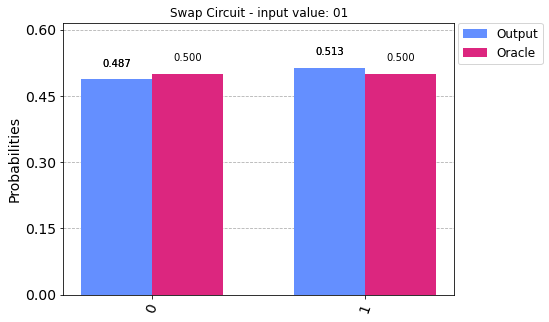

In [14]:
plot_histogram([outputs['01'], oracle['01']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 01")

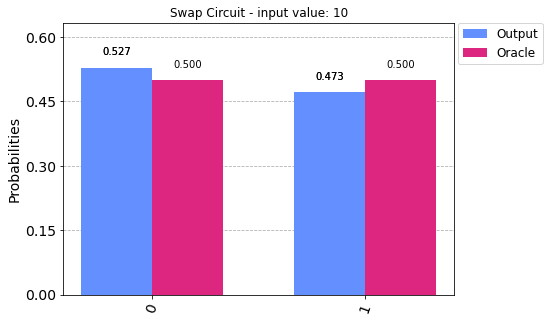

In [15]:
plot_histogram([outputs['10'], oracle['10']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 10")

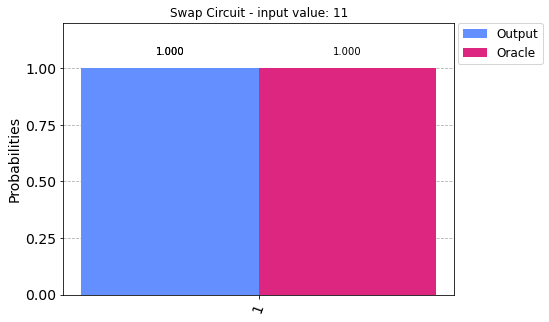

In [16]:
plot_histogram([outputs['11'], oracle['11']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 11")

Si para este mismo ejemplo pasamos, en vez del circuito original, uno modificado (en concreto, cambiando la segunda puerta hadamard por una not), podemos comprobar como nuestra herramoienta detecta que el circuito está mal implementado.

In [17]:
input_array = test_input_generator(num_input_qubits=2, mode="auto", test_list=[1])
#print(input_array)

# Instantiate the quantum circuit under test
qc = qc1_fail()

oracle = {'00':{'1':1},'01':{'0':0.5, '1':0.5},'10':{'0':0.5, '1':0.5},'11':{'1':1}}

outputs, oracle_superp = QPTT(qc, 2, oracle, inputs_array=input_array)

Circuit failed evaluation for input [0, 0]! There is some error.
Circuit returned {'1': 529, '0': 495}
Circuit passed evaluation for input [0, 1].
Circuit passed evaluation for input [1, 0].
Circuit failed evaluation for input [1, 1]! There is some error.
Circuit returned {'1': 527, '0': 497}


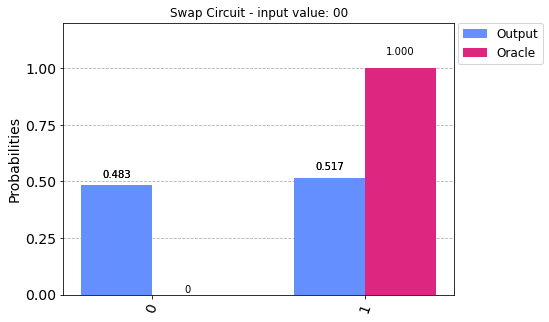

In [18]:
plot_histogram([outputs['00'], oracle['00']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 00")

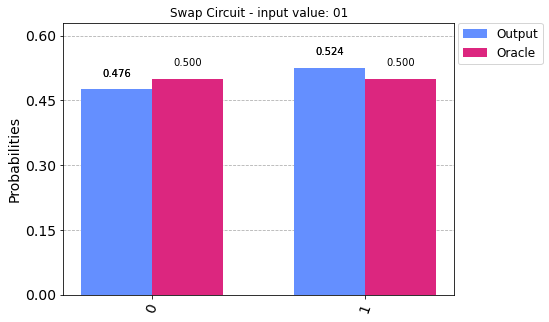

In [19]:
plot_histogram([outputs['01'], oracle['01']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 01")

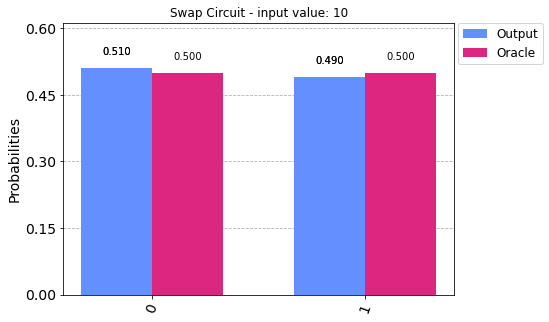

In [20]:
plot_histogram([outputs['10'], oracle['10']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 10")

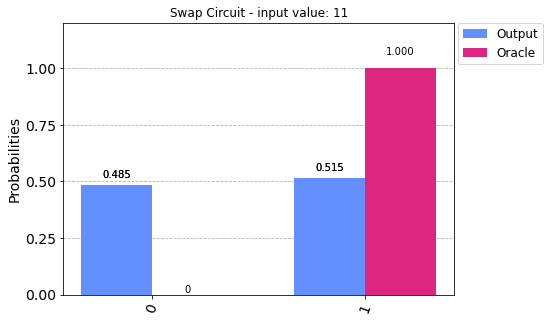

In [21]:
plot_histogram([outputs['11'], oracle['11']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 11")

El segundo ejemplo es usando la herramienta para testear el input 1 (01) del programa qc1:

In [22]:
input_array = test_input_generator(num_input_qubits=2, mode="custom", test_list=[1])
#print(input_array)

# Instantiate the quantum circuit under test
qc = qc1()

oracle = {'01':{'0':0.5, '1':0.5}}

outputs, oracle_superp = QPTT(qc, 2, oracle, inputs_array=input_array)

Circuit passed evaluation for input [0, 1].


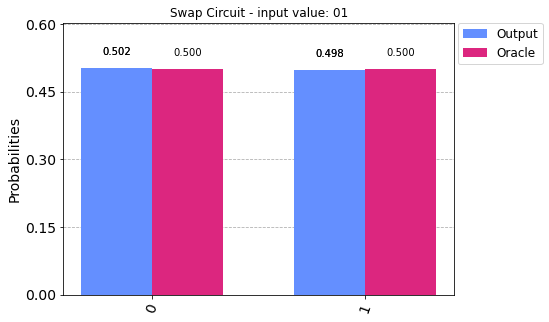

In [23]:
plot_histogram([outputs['01'], oracle['01']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 01")

Si en este mismo ejemplo modificamos el oráculo, podemos observar cómo el programa detecta que los outputs y el oráculo no corresponden a la misma distribución de probabilidad.

In [24]:
input_array = test_input_generator(num_input_qubits=2, mode="custom", test_list=[1])
#print(input_array)

# Instantiate the quantum circuit under test
qc = qc1()

oracle = {'01':{'0':0.25, '1':0.75}}

outputs, oracle_superp = QPTT(qc, 2, oracle, inputs_array=input_array)

Circuit failed evaluation for input [0, 1]! There is some error.
Circuit returned {'1': 483, '0': 541}


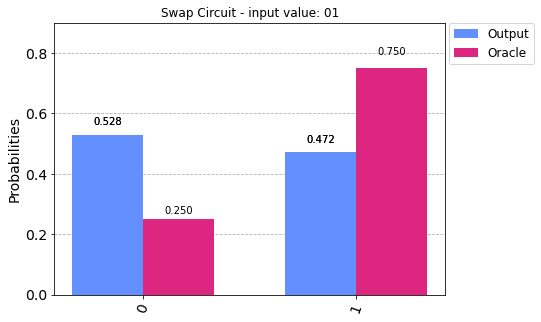

In [25]:
plot_histogram([outputs['01'], oracle['01']], legend=['Output', 'Oracle'], title="Swap Circuit - input value: 01")

El tercer ejemplo es usando la herramienta para testear la superposición de los inputs del programa qc2 que consiste en una puerta toffoli. En este circuito el programa internamente ha creado un oráculo a partir de los oráculos individuales de forma que el oráculo final era que un cuarto de las ejecuciones deberían devolver 1, tal y como se esperaría de una toffoli en superposición.

In [26]:
# Instantiate the quantum circuit under test
qc = qc2()

oracle = {'00':{'0':1},'01':{'0':1},'10':{'0':1},'11':{'1':1}}

outputs, oracle_superp = QPTT(qc, 2, oracle)

Circuit passed evaluation.


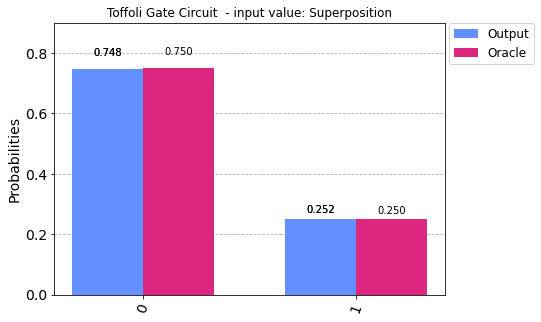

In [27]:
plot_histogram([outputs, oracle_superp], legend=['Output', 'Oracle'], title="Toffoli Gate Circuit  - input value: Superposition")

Y finalmente el cuarto ejemplo es usando la herramienta para testear la superposición de los inputs del programa qc1. En este circuito el programa internamente ha creado un oráculo a partir de los oráculos individuales, pero sin embargo, debido a la naturaleza del circuito, esta generación automática ha fallado.

In [28]:
# Instantiate the quantum circuit under test
qc = qc1()

oracle = {'00':{'1':1},'01':{'0':0.5, '1':0.5},'10':{'0':0.5, '1':0.5},'11':{'1':1}}

outputs, oracle_superp = QPTT(qc, 2, oracle)

Circuit failed evaluation! There is some error.
Circuit returned {'1': 1024}


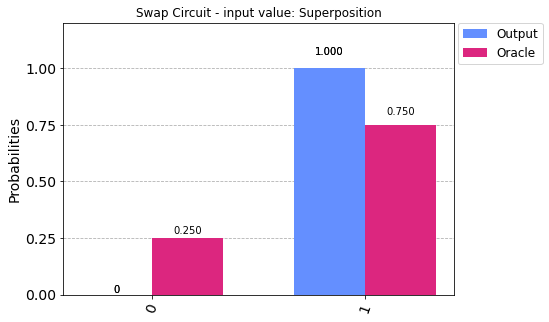

In [29]:
plot_histogram([outputs, oracle_superp], legend=['Output', 'Oracle'], title="Swap Circuit - input value: Superposition")